In [1]:
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
from keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
from keras.layers import Flatten, LSTM, Dropout, Bidirectional, Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate, Conv2DTranspose, BatchNormalization, Activation, ConvLSTM2D
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pickle

import matplotlib.pyplot as plt
from matplotlib.path import Path
import cv2

from keras.preprocessing.image import img_to_array, array_to_img


In [2]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix

In [3]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [4]:
with open('train.npy', 'rb') as f:
    train_frames = np.load(f)
    train_masks = np.load(f)
with open('val.npy', 'rb') as f:
    val_frames = np.load(f)
    val_masks = np.load(f) 
with open('test.npy', 'rb') as f:
    test_frames = np.load(f)
    test_masks = np.load(f)

In [24]:
def my_weighted_loss(labels, logits):
    """scale loss based on class weights
    """
    # reshape 
    labels = tf.reshape(labels, [-1,1])
    logits = tf.reshape(logits, [-1,1])
    # compute weights based on their frequencies (higher weight to class 1 since it's less common)
    class_weights = [1., 3.]
    # compute weights based on labels
    labels = tf.cast(labels, tf.float32)
    weights = labels*(class_weights[1]-class_weights[0]) + class_weights[0]
    
    weights = tf.reshape(weights, [-1])
    
    
    # compute (unweighted) softmax cross entropy loss
    unweighted_losses = tf.keras.losses.binary_crossentropy(labels, logits)
    # apply the weights, relying on broadcasting of the multiplication
    weighted_losses = unweighted_losses * weights
    # reduce the result to get your final loss
    loss = tf.reduce_mean(weighted_losses)
    return loss

In [25]:
# Create BCDU net model for object detection

# scale decrease to downsize the model (for ram and/or training time)
sd = 2
input_size = (112,112,1)
N_1 = input_size[0]
N_2 = input_size[1]
inputs = Input(input_size) 
conv1 = Conv2D(int(64/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(int(64/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(int(128/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(int(128/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(int(256/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(int(256/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
# D1
conv4 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
conv4_1 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4_1 = Dropout(0.5)(conv4_1)
# D2
conv4_2 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
conv4_2 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
conv4_2 = Dropout(0.5)(conv4_2)
# D3
merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
conv4_3 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
conv4_3 = Conv2D(int(512/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
drop4_3 = Dropout(0.5)(conv4_3)

up6 = Conv2DTranspose(int(256/sd), kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
up6 = BatchNormalization(axis=3)(up6)
up6 = Activation('relu')(up6)

x1 = Reshape(target_shape=(1, np.int32(N_1/4), np.int32(N_2/4), int(256/sd)))(drop3)
x2 = Reshape(target_shape=(1, np.int32(N_1/4), np.int32(N_2/4), int(256/sd)))(up6)
merge6  = concatenate([x1,x2], axis = 1) 
merge6 = ConvLSTM2D(filters = int(128/sd), kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)
            
conv6 = Conv2D(int(256/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(int(256/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2DTranspose(int(128/sd), kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
up7 = BatchNormalization(axis=3)(up7)
up7 = Activation('relu')(up7)

x1 = Reshape(target_shape=(1, np.int32(N_1/2), np.int32(N_2/2), int(128/sd)))(conv2)
x2 = Reshape(target_shape=(1, np.int32(N_1/2), np.int32(N_2/2), int(128/sd)))(up7)
merge7  = concatenate([x1,x2], axis = 1) 
merge7 = ConvLSTM2D(filters = int(64/sd), kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
conv7 = Conv2D(int(128/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(int(128/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2DTranspose(int(64/sd), kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
up8 = BatchNormalization(axis=3)(up8)
up8 = Activation('relu')(up8)    

x1 = Reshape(target_shape=(1, N_1, N_2, int(64/sd)))(conv1)
x2 = Reshape(target_shape=(1, N_1, N_2, int(64/sd)))(up8)
merge8  = concatenate([x1,x2], axis = 1) 
merge8 = ConvLSTM2D(filters = int(32/sd), kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
conv8 = Conv2D(int(64/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(int(64/sd), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)
# trying this out in order to weight the samples...
# outputs = Reshape((N_1*N_2, 1))(conv9)

model = Model(inputs = inputs, outputs = conv9)
model.compile(optimizer = Adam(lr = 1e-3), loss = my_weighted_loss, metrics = ['accuracy'])
# model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()
# plot_model(model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 112, 112, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 112, 112, 32  9248        ['conv2d_20[0][0]']              
                                )                                                           

C:\Users\Owner\anaconda3\envs\tf2.7\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
train_X = tf.constant(train_frames)
train_y = tf.constant(train_masks)
train_X.shape, train_y.shape

(TensorShape([14920, 112, 112, 3]), TensorShape([14920, 112, 112]))

In [27]:
train_X = tf.expand_dims(tf.reduce_mean(train_X, axis=3), axis=-1)
train_y = tf.expand_dims(train_y, axis=-1)

In [28]:
val_X = tf.constant(val_frames)
val_y = tf.constant(val_masks)
val_X = tf.expand_dims(tf.reduce_mean(val_X, axis=3), axis=-1)
val_y = tf.expand_dims(val_y, axis=-1)

In [29]:
# only run this line after you've run this file at least once
model.load_weights('segmentation_model.h5')

In [30]:
# parameters makes the mean equal 0, and divides by standard deviation (basically get z-score as output)
# https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/
# my_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
my_generator = ImageDataGenerator(rescale=1./255)
# my_generator.fit(train_X)
batch_size = 16

train_data = my_generator.flow(train_X, train_y, batch_size = batch_size)
val_data = my_generator.flow(val_X, val_y, batch_size = batch_size)
model.fit_generator(train_data, epochs = 5, steps_per_epoch = len(train_data),  validation_data = val_data, validation_steps=len(val_data))

C:\Users\Owner\AppData\Local\Temp/ipykernel_5032/247338061.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data, epochs = 5, steps_per_epoch = len(train_data),  validation_data = val_data, validation_steps=len(val_data))


Epoch 1/5
933/933 [==============================] - 457s 479ms/step - loss: 0.0475 - accuracy: 0.9849 - val_loss: 0.0607 - val_accuracy: 0.9813
Epoch 2/5
933/933 [==============================] - 448s 480ms/step - loss: 0.0471 - accuracy: 0.9851 - val_loss: 0.0593 - val_accuracy: 0.9837
Epoch 3/5
933/933 [==============================] - 448s 480ms/step - loss: 0.0459 - accuracy: 0.9854 - val_loss: 0.0587 - val_accuracy: 0.9823
Epoch 4/5
933/933 [==============================] - 448s 480ms/step - loss: 0.0451 - accuracy: 0.9856 - val_loss: 0.0585 - val_accuracy: 0.9837
Epoch 5/5
933/933 [==============================] - 448s 480ms/step - loss: 0.0450 - accuracy: 0.9857 - val_loss: 0.0606 - val_accuracy: 0.9838


In [31]:
test_X = tf.constant(test_frames)
test_y = tf.constant(test_masks)
test_X = tf.expand_dims(tf.reduce_mean(test_X, axis=3), axis=-1)
test_y = tf.expand_dims(test_y, axis=-1)

In [32]:
predictions = model.predict(test_X)

In [33]:
predictions.shape

(2552, 112, 112, 1)

In [34]:
predicted_label = np.where(predictions > 0.5, 1, 0)
predicted_label.shape

(2552, 112, 112, 1)

In [35]:
p_l = tf.constant(predicted_label)
t_l = tf.cast(tf.constant(test_y), dtype='int32')

In [36]:
# jaccard_score(v_l, p_l, pos_label=1, average="binary")
jaccard_score(tf.reshape(t_l, [-1]), tf.reshape(p_l, [-1]), pos_label=1, average="binary")

0.642940103815908

<AxesSubplot:>

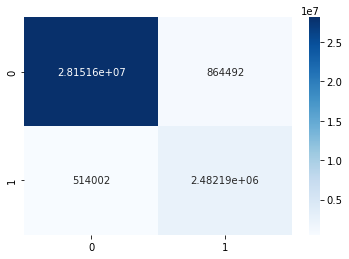

In [37]:
import seaborn as sns
cf_matrix = confusion_matrix(tf.reshape(t_l, [-1]), tf.reshape(p_l, [-1]))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
# too many false negatives, let's run again with more weight on the "positive" pixels

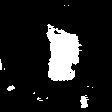

In [38]:
predicted_image_labels = []
for i in predicted_label:
    image = array_to_img(i)
    predicted_image_labels.append(image)
predicted_image_labels[0]

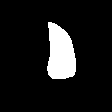

In [39]:
test_image_labels = []
for i in test_y:
    image = array_to_img(i)
    test_image_labels.append(image)
test_image_labels[0]

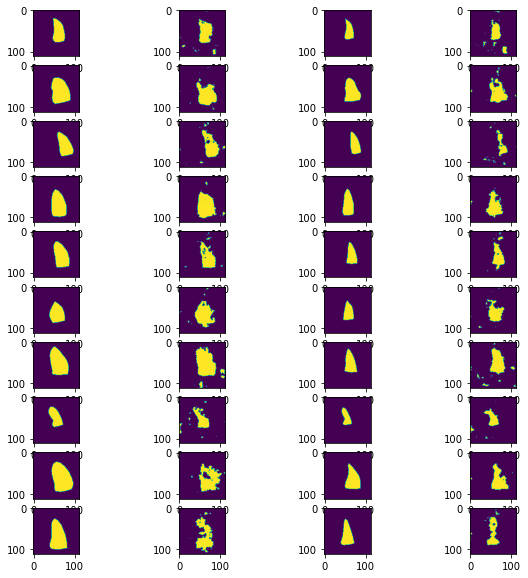

In [40]:
num_rows = 10
f, axarr = plt.subplots(num_rows,4,figsize=(10,10))
for i in range(num_rows):
    axarr[i,0].imshow(test_image_labels[i*2])
    axarr[i,1].imshow(predicted_image_labels[i*2])
    axarr[i,2].imshow(test_image_labels[i*2+1])
    axarr[i,3].imshow(predicted_image_labels[i*2+1])

In [41]:
# model.save('segmentation_model.h5')